In [419]:
import torchsde
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Union, Tuple

In [420]:
class ControlledLinearSDE(torchsde.SDEIto):
    def __init__(self, A: torch.Tensor, B: torch.Tensor, Beta: torch.tensor):
        super().__init__(noise_type="general")  # dW has same dim as x
        self.A = A                                # (n, n)
        self.B = B                                # (n, m)
        self.Beta = Beta                          # (n, q)

    def u(self, t: torch.Tensor, batch_size, m) -> torch.Tensor:
        w = torch.linspace(1, 5, m)
        u = torch.sin(t[..., None] * w)                            # (m,) or (N,m)

        if t.ndim == 0:                                            # scalar -> (batch,m)
            return u.unsqueeze(0).expand(batch_size, -1)
        else:                                                      # (N,) -> (N,batch,m)
            return u.unsqueeze(1).expand(-1, batch_size, -1)

    def f(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Drift: f(t,x) = A x + B u(t)
        x shape: (batch, n)
        """
        # A x
        batch_size, _ = x.shape
        ut = self.u(t, batch_size, m).to(x)   # (batch, m)
        Ax = x @ self.A.T                            # (batch, n)
        But = ut @ self.B.T                          # (batch, n)
        return Ax + But

    def g(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Diffusion: g(t,x) = Beta  (additive noise)
        For noise_type="general", must return (batch, n, q).
        """
        batch_size, _ = x.shape
        return self.Beta.unsqueeze(0).expand(batch_size, -1, -1).to(x)

In [421]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

T = 100.0
dt = 0.1
n, m, q = 10, 5, 2
batch = 1

A = torch.randn(n, n, device=device)
A = A - (torch.linalg.eigvals(A).real.max() + 0.1) * torch.eye(n, device=device, dtype=A.dtype)

B = torch.randn(n, m, device=device)
Beta = torch.randn((n,q))/n

sde = ControlledLinearSDE(A, B, Beta).to(device)

In [422]:
ts = torch.linspace(0.0, T, int(T/dt)+1, device=device)  # time grid
x0 = torch.zeros(batch, n, device=device)            # initial condition

# Simulate sample path (Euler–Maruyama)
x = torchsde.sdeint(sde, x0, ts, method="euler", dt_min=dt)[:,0]  # (len(ts), batch, n)
u = sde.u(ts, batch, m)[:,0]
print("x.shape =", x.shape)        # (len(ts), batch, n)
print("u.shape =", u.shape)        # (len(ts), batch, n

x.shape = torch.Size([1001, 10])
u.shape = torch.Size([1001, 5])


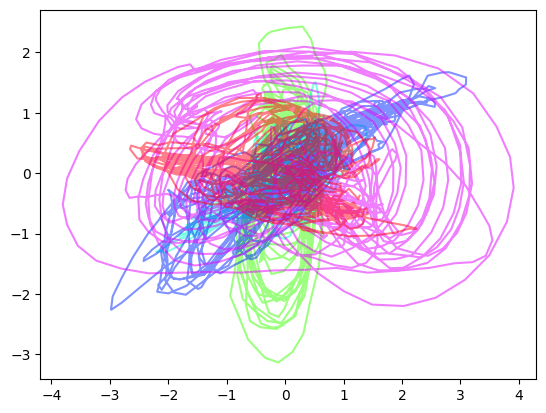

In [423]:
blues = plt.cm.hsv(np.linspace(0.3, 1.0, n//2))
for idx, i in enumerate(range(0,n,2)):
  plt.plot(x[:, i].cpu().numpy(), x[:, i+1].cpu().numpy(),
             color=blues[idx], alpha=0.5)

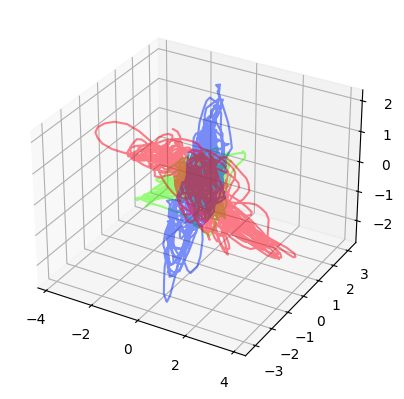

In [424]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate different shades of blue
blues = plt.cm.hsv(np.linspace(0.3, 1.0, n//3))

for i in range(n//3):
    ax.plot(x[:, 3*i].cpu().numpy(),
            x[:, 3*i+1].cpu().numpy(),
            x[:, 3*i+2].cpu().numpy(),
            color=blues[i], alpha=0.5)

plt.show()

In [425]:
def _complex_dtype_from_real(real_dtype: torch.dtype) -> torch.dtype:
    return torch.complex64 if real_dtype == torch.float32 else torch.complex128

def _to_complex(x: torch.Tensor, complex_dtype: torch.dtype) -> torch.Tensor:
    return x if torch.is_complex(x) else x.to(complex_dtype)


def stack_z(x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    return torch.cat([x, u], dim=-1)

In [426]:
def gramian_Sz_time(
    x: torch.Tensor,
    u: torch.Tensor,
    dt: Union[float, torch.Tensor],
) -> torch.Tensor:
    r"""
    S_Z = ∫ z z^T dt  ≈  Σ_{k=0}^{N-2} z_k z_k^T Δt_k
    where z_k = [x_k; u_k] (left point)

    Args:
        x: (N, n)
        u: (N, m)
        dt: scalar float OR tensor (N-1,) of time steps

    Returns:
        Sz: (n+m, n+m) real matrix
    """
    assert x.ndim == 2 and u.ndim == 2, "Expected x:(N,n), u:(N,m)"
    assert x.shape[0] == u.shape[0], "x and u must have the same length N"

    N = x.shape[0]
    assert N >= 2, "Need at least 2 samples"

    z = stack_z(x[:-1], u[:-1])  # (N-1, p)
    p = z.shape[1]

    if isinstance(dt, (float, int)):
        dt_vec = torch.full((N - 1,), float(dt), device=z.device, dtype=z.dtype)
    else:
        dt_vec = dt.to(device=z.device, dtype=z.dtype)
        assert dt_vec.shape == (N - 1,), f"dt must have shape (N-1,) = {(N-1,)}, got {dt_vec.shape}"

    # Sz = Σ dt_k z_k z_k^T
    Sz = z.transpose(0, 1) @ (z * dt_vec[:, None])  # (p,p)
    return Sz

def integral_xxH_time(
    x: torch.Tensor,
    dt: Union[float, int, torch.Tensor],
) -> torch.Tensor:
    r"""
    ∫_0^T x(t) x(t)^* dt  ≈  Σ_{k=0}^{N-2} x_k x_k^* Δt_k   (left-point)

    Args:
        x:  (N, n)   (real or complex)
        dt: scalar float/int OR tensor (N-1,) of time steps

    Returns:
        Sx: (n, n)
    """
    assert x.ndim == 2, "Expected x:(N,n)"
    N, n = x.shape
    assert N >= 2, "Need at least 2 samples"

    device = x.device
    # left-point samples
    x0 = x[:-1]  # (N-1, n)

    # dt handling
    if isinstance(dt, (float, int)):
        dt_vec = torch.full((N - 1,), float(dt), device=device, dtype=torch.float32)
    else:
        dt_vec = dt.to(device=device)
        assert dt_vec.shape == (N - 1,), f"dt must have shape (N-1,), got {dt_vec.shape}"

    # ensure dt is real-valued tensor type for scaling
    dt_vec = dt_vec.to(dtype=torch.float32 if not x0.is_complex() else torch.float32)

    # Sx = Σ dt_k x_k x_k^*
    # (n,N-1) @ (N-1,n) -> (n,n)
    Sx = x0.conj().transpose(0, 1) @ (x0 * dt_vec[:, None].to(x0.dtype))
    return Sx


def integral_xdot_xH_time(
    x: torch.Tensor,
    dt: Union[float, int, torch.Tensor],
    use_dx: bool = True,
) -> torch.Tensor:
    r"""
    ∫_0^T xdot(t) x(t)^* dt  ≈  Σ_{k=0}^{N-2} xdot_k x_k^* Δt_k   (left-point)

    Two equivalent discretizations:
      - use_dx=True (recommended):  xdot_k Δt_k ≈ Δx_k  => Σ Δx_k x_k^*
      - use_dx=False: xdot_k ≈ Δx_k/Δt_k => Σ (Δx_k/Δt_k) x_k^* Δt_k

    Args:
        x:   (N, n)   (real or complex)
        dt:  scalar float/int OR tensor (N-1,)
        use_dx: avoids division by dt (more stable)

    Returns:
        M: (n, n)
    """
    assert x.ndim == 2, "Expected x:(N,n)"
    N, n = x.shape
    assert N >= 2, "Need at least 2 samples"

    device = x.device
    x0 = x[:-1]          # (N-1, n) left point
    dx = x[1:] - x[:-1]  # (N-1, n)

    # dt handling
    if isinstance(dt, (float, int)):
        dt_vec = torch.full((N - 1,), float(dt), device=device, dtype=torch.float32)
    else:
        dt_vec = dt.to(device=device)
        assert dt_vec.shape == (N - 1,), f"dt must have shape (N-1,), got {dt_vec.shape}"
        dt_vec = dt_vec.to(dtype=torch.float32)

    if use_dx:
        # M = Σ Δx_k x_k^*
        M = dx.transpose(0, 1) @ x0.conj()
    else:
        # xdot_k ≈ Δx_k / Δt_k
        xdot = dx / dt_vec[:, None].to(dx.dtype)
        # M = Σ xdot_k x_k^* Δt_k
        M = xdot.transpose(0, 1) @ (x0.conj() * dt_vec[:, None].to(x0.dtype))

    return M

In [427]:
def cross_moment_H_time(
    x: torch.Tensor,
    u: torch.Tensor,
    lam: Union[complex, torch.Tensor],
    dt: Union[float, torch.Tensor],
    return_parts: bool = False,
) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]:
    r"""
    Time-domain (increment) estimator of:
        H_λ(T) = ∫ d y_λ(t) z(t)^T
    with:
        d y_λ(t) = d x(t) - λ x(t) dt

    Discrete left-point sum:
        H_λ ≈ Σ_{k=0}^{N-2} (Δx_k - λ x_k Δt_k) z_k^T
    where z_k = [x_k; u_k].

    Args:
        x: (N, n)
        u: (N, m)
        lam: complex scalar
        dt: scalar float OR tensor (N-1,)
        return_parts: if True returns (H_lambda, H_dx, H_xdt)
            H_dx  = Σ Δx_k z_k^T
            H_xdt = Σ (x_k Δt_k) z_k^T

    Returns:
        H_lambda: (n, n+m) complex
    """
    assert x.ndim == 2 and u.ndim == 2, "Expected x:(N,n), u:(N,m)"
    assert x.shape[0] == u.shape[0], "x and u must have the same length N"

    device = x.device
    real_dtype = x.dtype
    complex_dtype = _complex_dtype_from_real(real_dtype)

    N, n = x.shape
    m = u.shape[1]
    assert N >= 2, "Need at least 2 samples"

    lam_c = lam if isinstance(lam, torch.Tensor) else torch.tensor(lam, device=device)
    lam_c = _to_complex(lam_c, complex_dtype)

    dx = x[1:] - x[:-1]          # (N-1, n)
    x0 = x[:-1]                  # (N-1, n)
    u0 = u[:-1]                  # (N-1, m)
    z0 = stack_z(x0, u0)         # (N-1, n+m)

    # dt handling
    if isinstance(dt, (float, int)):
        dt_vec = torch.full((N - 1,), float(dt), device=device, dtype=real_dtype)
    else:
        dt_vec = dt.to(device=device, dtype=real_dtype)
        assert dt_vec.shape == (N - 1,), f"dt must have shape (N-1,), got {dt_vec.shape}"

    dx_c = _to_complex(dx, complex_dtype)
    x0_c = _to_complex(x0, complex_dtype)
    z0_c = _to_complex(z0, complex_dtype)

    # H_dx = Σ Δx_k z_k^T
    H_dx = torch.einsum("kn,kp->np", dx_c, z0_c)  # (n, p)

    # H_xdt = Σ (x_k Δt_k) z_k^T
    xdt = x0_c * dt_vec[:, None].to(complex_dtype)
    H_xdt = torch.einsum("kn,kp->np", xdt, z0_c)  # (n, p)

    H_lam = H_dx - lam_c * H_xdt

    if return_parts:
        return H_lam, H_dx, H_xdt
    return H_lam

In [433]:
def _get_window(N: int, device, dtype, kind: Optional[str]) -> Optional[torch.Tensor]:
    if kind is None:
        return None
    kind = kind.lower()
    n = torch.arange(N, device=device, dtype=dtype)
    if kind == "hann":
        return 0.5 * (1.0 - torch.cos(2.0 * np.pi * n / (N - 1)))
    if kind == "hamming":
        return 0.54 - 0.46 * torch.cos(2.0 * np.pi * n / (N - 1))
    raise ValueError(f"Unknown window kind: {kind}")

def cross_moment_H_fft(
    x: torch.Tensor,   # (N,n)
    u: torch.Tensor,   # (N,m)
    lam: Union[complex, torch.Tensor],
    dt: float,
    omega_max: Optional[float] = None,
    return_parts: bool = False,
):
    assert x.ndim == 2 and u.ndim == 2
    assert x.shape[0] == u.shape[0]
    device = x.device
    real_dtype = x.dtype
    complex_dtype = torch.complex64 if real_dtype == torch.float32 else torch.complex128
    N, n = x.shape
    m = u.shape[1]
    p = n + m

    lam_c = lam if isinstance(lam, torch.Tensor) else torch.tensor(lam, device=device)
    lam_c = lam_c.to(dtype=complex_dtype)

    # z(t) = [x; u]
    z = torch.cat([x, u], dim=1)  # (N,p)

    # Frequency grid (angular)
    omega = 2.0 * np.pi * torch.fft.fftfreq(N, d=dt).to(device=device, dtype=real_dtype)

    # FFT approximations of integrals
    Xhat = dt * torch.fft.fft(x.to(complex_dtype), dim=0)  # (N,n)
    Zhat = dt * torch.fft.fft(z.to(complex_dtype), dim=0)  # (N,p)

    # --- CRITICAL FIX ---
    # Approximate ∫ e^{-iωt} dx(t) by FFT of increments Δx_k = x_{k+1}-x_k
    dx = torch.zeros_like(x)
    dx[:-1] = x[1:] - x[:-1]           # (N,n) with last entry = 0
    DXhat = torch.fft.fft(dx.to(complex_dtype), dim=0)  # (N,n), NO dt factor

    # dyhat_λ = (∫ e^{-iωt} dx) - λ (∫ e^{-iωt} x dt)
    DYhat = DXhat - lam_c * Xhat  # (N,n)

    # Optional frequency cutoff
    if omega_max is not None:
        mask = omega.abs() <= omega_max
        DYhat = DYhat[mask]
        Xhat = Xhat[mask]
        Zhat = Zhat[mask]

    # Parseval scaling: Δω/(2π) = 1/(N dt)
    scale = 1.0 / (N * dt)

    # Hλ = ∫ dyλ z*  ≈ Σ DYhat Zhat* Δω/(2π)
    H_lam = (DYhat.transpose(0, 1) @ Zhat.conj()) * scale  # (n,p)

    # Also return Sz if needed
    Sz = (Zhat.transpose(0, 1) @ Zhat.conj()) * scale      # (p,p)

    if return_parts:
        # If you want the split:
        # H0 = ∫ dx z*   and Hx = ∫ x z*
        H0 = (DXhat.transpose(0, 1) @ Zhat.conj()) * scale
        Hx = (Xhat.transpose(0, 1)  @ Zhat.conj()) * scale
        return H_lam, H0, Hx, Sz

    return H_lam, Sz

def gramian_G_from_H(H: torch.Tensor, Sz: torch.Tensor, ridge: float = 0.0) -> torch.Tensor:
    """
    G_λ = H S_Z^{-1} H^*
    computed stably via solve rather than inv.
    """
    p = Sz.shape[-1]
    Sz_type = _complex_dtype_from_real(Sz.dtype)
    Sz_reg = Sz + ridge * torch.eye(p, device=Sz.device, dtype=Sz_type)

    # Solve Sz_reg * X = H^*
    X = torch.linalg.solve(Sz_reg, H.conj().transpose(-2, -1))  # (p, n)
    return H @ X  # (n, n)

def Hautus_matrix_P_from_H(H: torch.Tensor, Sz: torch.Tensor, ridge: float = 0.00) -> torch.Tensor:
    """
    P_λ = H S_Z^{-1}
    """
    p = Sz.shape[-1]
    Sz_type = _complex_dtype_from_real(Sz.dtype)
    H = H.to(dtype=Sz_type)
    Sz_reg = Sz + torch.eye(p, device=Sz.device, dtype=Sz_type) * ridge
    return torch.linalg.solve(Sz_reg, H.conj().transpose(-2, -1)).conj().transpose(-2, -1)

In [429]:
lam = 0.3 + 1.3j
H1 = cross_moment_H_time(x, u, lam=lam, dt=dt)
H2, Sz2 = cross_moment_H_fft(x, u, lam=lam, dt=dt, omega_max=100)
Sz = gramian_Sz_time(x, u, dt=dt)
#G = gramian_G_from_H(H1, Sz, ridge=1e-8)

P = torch.cat([A - lam*torch.eye(n), B], dim=1)
P1 = Hautus_matrix_P_from_H(H1, Sz, ridge=1e-8)
P2 = Hautus_matrix_P_from_H(H2, Sz2, ridge=1e-8)

P_eigvals = torch.linalg.svdvals(P)
P1_eigvals = torch.linalg.svdvals(P1)
P2_eigvals = torch.linalg.svdvals(P2)

print("$P (original) \t\t= $", P_eigvals.min().item())
print("$P (approximated) \t= $", P1_eigvals.min().item())
print("$P (approximated fft) \t= $", P2_eigvals.min().item())

torch.complex64
$P (original) 		= $ 1.7619684934616089
$P (approximated) 	= $ 1.3983806371688843
$P (approximated fft) 	= $ 1.4167107111988206


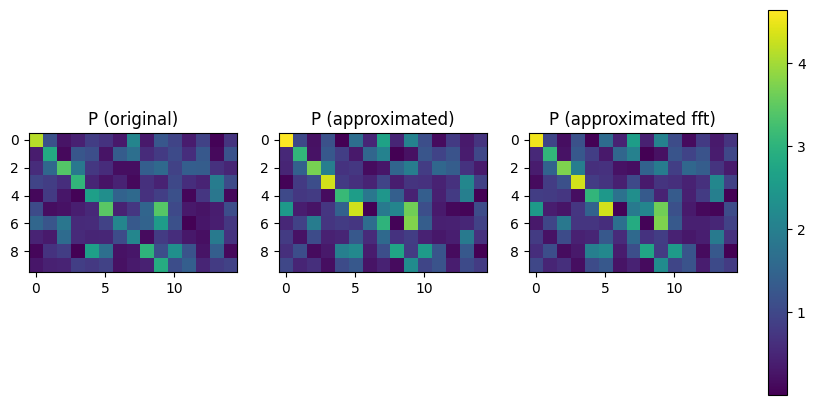

In [430]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

vmin = min(P1.absolute().min(), P2.absolute().min())
vmax = max(P1.absolute().max(), P2.absolute().max())
im0 = axs[0].imshow(P.absolute(), vmin=vmin, vmax=vmax,  cmap='viridis')
im1 = axs[1].imshow(P1.absolute(), vmin=vmin, vmax=vmax,  cmap='viridis')
im2 = axs[2].imshow(P2.absolute(), vmin=vmin, vmax=vmax,  cmap='viridis')
axs[0].set_title("P (original)")
axs[1].set_title("P (approximated)")
axs[2].set_title("P (approximated fft)")
fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)

In [431]:
Sx = integral_xxH_time(x, dt)             # ∫ x x^* dt
Mx = integral_xdot_xH_time(x, dt)         # ∫ xdot x^* dt

K = torch.linalg.inv(Sx) @ Mx
lambs = torch.linalg.eigvals(K)

In [434]:
min_eval = np.inf
min_eval1 = np.inf
min_eval2 = np.inf

for lam in lambs:
  H1 = cross_moment_H_time(x, u, lam=lam, dt=dt)
  H2, Sz2 = cross_moment_H_fft(x, u, lam=lam, dt=dt, omega_max=100)
  Sz = gramian_Sz_time(x, u, dt=dt)
  #G = gramian_G_from_H(H1, Sz, ridge=1e-8)

  P = torch.cat([A - lam*torch.eye(n), B], dim=1)
  P1 = Hautus_matrix_P_from_H(H1, Sz, ridge=1e-8)
  P2 = Hautus_matrix_P_from_H(H2, Sz2, ridge=1e-8)

  P_eigvals = torch.linalg.svdvals(P).min().item()
  P1_eigvals = torch.linalg.svdvals(P1).min().item()
  P2_eigvals = torch.linalg.svdvals(P2).min().item()

  min_eval = min(min_eval, P_eigvals)
  min_eval1 = min(min_eval1, P1_eigvals)
  min_eval2 = min(min_eval2, P2_eigvals)

In [435]:
print(min_eval)
print(min_eval1)
print(min_eval2)

1.2514561414718628
1.1002957820892334
1.067157471617703


In [436]:
min_eval = np.inf
for lam in torch.linalg.eigvals(A):
  P = torch.cat([A - lam*torch.eye(n), B], dim=1)
  min_eval = min(min_eval, P_eigvals)
print(min_eval)

1.6678115129470825
